In [37]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy.ma as ma

In [2]:
df = pd.read_csv( "data_W.csv" )
out_path = "./img3/"

In [3]:
# Funzione di ordinamento numerico robusta
def sort_by_num(labels):
    """Ordina etichette come S1..S10 o XS1..XS10 in base al numero finale."""
    return sorted(labels, key=lambda x: int(''.join([c for c in x if c.isdigit()])))

In [4]:
factor_cols = ['rmrf', 'smb', 'hml', 'umd']
xs_w_cols = [f'XS{i}_W' for i in range(1, 11)]

use_w = df[xs_w_cols + factor_cols].dropna().copy()

X = sm.add_constant(use_w[factor_cols])  # aggiunge l'intercetta

# --- run OLS for each XS ---
results_w = {}  # per riusare nei punti successivi
for xs_w in xs_w_cols:
    y = use_w[xs_w]
    model = sm.OLS(y, X)
    results_w[xs_w] = model.fit()

results_w = {k.replace('_W', ''): v for k, v in results_w.items()}

In [5]:
# estraiamo betas e alpha in un DataFrame indicizzato per portfolio (XS1..XS10)
rows = []
for k, res in results_w.items():
    params = res.params  # index: ['const','rmrf','smb','hml','umd']
    rows.append({
        "portfolio": k,                # XS1..XS10
        "alpha": float(params.get("const", np.nan)),
        "beta_M": float(params["rmrf"]),
        "beta_SMB": float(params["smb"]),
        "beta_HML": float(params["hml"]),
        "beta_UMD": float(params["umd"]),
        "r2": res.rsquared,
        "r2_adj": res.rsquared_adj,
    })

ts_summary = pd.DataFrame(rows).set_index("portfolio")
ts_summary = ts_summary.loc[sort_by_num(ts_summary.index)] 
print("Time-series betas/alpha/metrics")
display(ts_summary)

Time-series betas/alpha/metrics


,alpha,beta_M,beta_SMB,beta_HML,beta_UMD,r2,r2_adj
portfolio,,,,,,,
XS1,0.005379,0.669732,0.833417,0.104161,0.095220,0.602309,0.597866
XS2,0.005661,0.746535,0.895935,0.055465,-0.029742,0.719466,0.716332
XS3,0.003461,0.744901,0.922583,0.073947,0.004086,0.777465,0.774979
XS4,0.002398,0.808085,1.004553,-0.106107,0.086681,0.829780,0.827878
XS5,0.001190,0.864139,0.904032,0.040708,0.053836,0.849612,0.847931
XS6,0.001816,0.893728,0.882555,0.020540,0.014411,0.887605,0.886349
XS7,0.001018,0.924632,0.844916,-0.016041,0.008724,0.907338,0.906303
XS8,0.000472,0.995537,0.724549,-0.034221,0.045609,0.925851,0.925022
XS9,0.001302,1.067398,0.451884,-0.008440,-0.060537,0.921052,0.920170


In [6]:
xs_cols = [f"XS{i}" for i in range(1, 11)]     # excess returns
mean_returns = df[xs_cols].mean().rename("mean_return")
mean_returns = mean_returns.loc[sort_by_num(mean_returns.index)]

print("Mean returns (ordinati XS1..XS10)")
mean_returns.to_frame().T

Mean returns (ordinati XS1..XS10)


,XS1,XS2,XS3,XS4,XS5,XS6,XS7,XS8,XS9,XS10
mean_return,0.010881,0.010486,0.008679,0.007937,0.007213,0.007588,0.006724,0.006622,0.006735,0.005052


In [7]:
betas = ts_summary[["beta_M","beta_SMB","beta_HML","beta_UMD"]].copy()
betas = betas.loc[sort_by_num(betas.index)] 

betas = betas.loc[mean_returns.index]

# Cross-section: mean returns ~ const + beta_M + beta_X
def run_cs_reg(y, Xdf, spec_name, add_const=True):
    X_ = sm.add_constant(Xdf) if add_const else Xdf.copy()
    res = sm.OLS(y.values, X_.values).fit()
    idx = (["const"] if add_const else []) + list(Xdf.columns)
    table = pd.DataFrame({"coef":res.params,"std_err":res.bse,"t":res.tvalues,"p>|t|":res.pvalues}, index=idx)
    metrics = pd.Series({"spec":spec_name,"n_obs":len(y),"r2":res.rsquared,"r2_adj":res.rsquared_adj})
    fitted = pd.Series(res.fittedvalues, index=y.index, name=f"fitted_{spec_name}")
    resid = y - fitted
    return table, metrics, fitted, resid, res

tab1, met1, fit1, resid1, _ = run_cs_reg(mean_returns, betas[["beta_M","beta_SMB"]], "M+SMB", add_const=True)
tab2, met2, fit2, resid2, _ = run_cs_reg(mean_returns, betas[["beta_M","beta_HML"]], "M+HML", add_const=True)
tab3, met3, fit3, resid3, _ = run_cs_reg(mean_returns, betas[["beta_M","beta_UMD"]], "M+UMD", add_const=True)

display(tab1, met1.to_frame().T)
display(tab2, met2.to_frame().T)
display(tab3, met3.to_frame().T)

,coef,std_err,t,p>|t|
const,0.015554,0.003215,4.838307,0.001881
beta_M,-0.010190,0.003140,-3.245503,0.014145
beta_SMB,0.001438,0.001126,1.277167,0.242272


,spec,n_obs,r2,r2_adj
0,M+SMB,10,0.751985,0.681124


,coef,std_err,t,p>|t|
const,0.016894,0.003084,5.477564,0.000928
beta_M,-0.010605,0.003487,-3.041364,0.018811
beta_HML,0.005728,0.007135,0.802799,0.448486


,spec,n_obs,r2,r2_adj
0,M+HML,10,0.719974,0.639967


,coef,std_err,t,p>|t|
const,0.020180,0.002655,7.601850,0.000126
beta_M,-0.013995,0.002946,-4.750736,0.002082
beta_UMD,-0.010985,0.007472,-1.470209,0.184968


,spec,n_obs,r2,r2_adj
0,M+UMD,10,0.766343,0.699584


In [19]:
def plot_cs_betas(tab1, tab2, tab3, out_path=out_path,
                  title="Cross-section lambdas (λ)",
                  filename="cs_betas.png"):
    """
    Crea un unico grouped bar chart con i coefficienti (λ) stimati nelle tre regressioni cross-section:
    - M+SMB: λ_M, λ_SMB
    - M+HML: λ_M, λ_HML
    - M+UMD: λ_M, λ_UMD
    Mostra le etichette numeriche sopra o sotto le barre a seconda del segno.
    """

    specs = [
        ("M+SMB", tab1, ["beta_M", "beta_SMB"]),
        ("M+HML", tab2, ["beta_M", "beta_HML"]),
        ("M+UMD", tab3, ["beta_M", "beta_UMD"]),
    ]

    groups = []
    vals = []
    for spec_name, tab, params in specs:
        available = [p for p in params if p in tab.index]
        coef = [tab.loc[p, "coef"] for p in available]
        while len(coef) < 2:
            coef.append(np.nan)
        vals.append(coef[:2])
        groups.append(spec_name)

    n_groups = len(groups)
    n_bars = 2
    group_gap = 1.0
    bar_width = 0.8
    x0 = np.arange(n_groups) * (n_bars + group_gap)

    fig, ax = plt.subplots(figsize=(7, 5))
    colors = plt.get_cmap('tab10')(np.linspace(0, 1, n_bars))
    labels = ["λ_M", "λ_X"]

    for j in range(n_bars):
        x = x0 + j
        heights = [vals[i][j] for i in range(n_groups)]
        bars = ax.bar(x, heights, width=bar_width, color=colors[j], label=labels[j])

        # etichette numeriche sopra/sotto le barre
        for rect in bars:
            h = rect.get_height()
            if np.isnan(h):
                continue
            y = h + 0.0001 if h >= 0 else h - 0.0001
            va = 'bottom' if h >= 0 else 'top'
            ax.text(rect.get_x() + rect.get_width()/2, y,
                    f"{h:.3f}", ha='center', va=va, fontsize=9)

    ax.set_xticks(x0 + (n_bars - 1) / 2)
    ax.set_xticklabels(groups)
    ax.axhline(0, color='black', linewidth=1)
    ax.set_ylabel('Coefficient (λ)')
    ax.set_title(title)
    ax.legend(frameon=False, loc='best')

    fig.tight_layout()
    fig.savefig(f"{out_path}{filename}", dpi=300, bbox_inches="tight")
    return fig

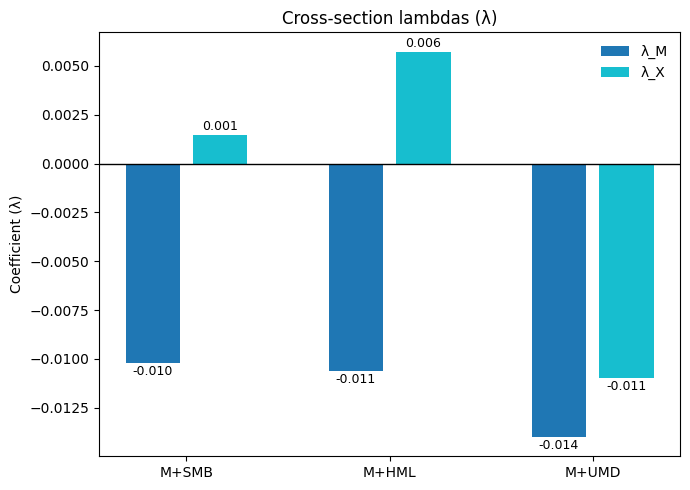

In [20]:
fig = plot_cs_betas(tab1, tab2, tab3, filename="cross-section_lambdas.png")

In [21]:
def plot_cs_pricing_errors(resid1, resid2, resid3, out_path=out_path,
                           title="Pricing errors by portfolio (cross-section)",
                           filename="cs_pricing_errors.png"):
    """
    Disegna un bar chart raggruppato dei residui per XS1..XS10
    nelle tre specifiche: M+SMB, M+HML, M+UMD.
    - resid1/resid2/resid3: pd.Series indicizzate per portfolio (XS1..XS10).
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd

    # Costruisci un DataFrame allineato sui portafogli
    df_res = pd.concat(
        {"M+SMB": resid1, "M+HML": resid2, "M+UMD": resid3},
        axis=1
    )

    # Ordina XS1..XS10 se possibile
    try:
        ordered_idx = sorted(df_res.index, key=lambda x: int(''.join([c for c in x if c.isdigit()])))
        df_res = df_res.loc[ordered_idx]
    except Exception:
        pass

    pf = df_res.index.tolist()
    specs = df_res.columns.tolist()
    n_pf = len(pf)
    n_specs = len(specs)

    group_gap = 0.8
    bar_width = 0.8
    x0 = np.arange(n_pf) * (n_specs + group_gap)

    fig, ax = plt.subplots(figsize=(max(8, 0.9*n_pf + 4), 5.2))
    colors = plt.get_cmap('tab10')(np.linspace(0, 1, n_specs))

    # Disegna una barra per specifica dentro a ciascun gruppo (portfolio)
    for j, spec in enumerate(specs):
        x = x0 + j
        ax.bar(x, df_res[spec].values, width=bar_width, label=spec, color=colors[j])

    # Assi e stile
    ax.set_xticks(x0 + (n_specs-1)/2)
    ax.set_xticklabels(pf, rotation=0)
    ax.axhline(0, color='black', linewidth=1)
    ax.set_ylabel("Pricing error (r̄_i - r̂_i)")
    ax.set_title(title)
    ax.legend(frameon=False, loc='best')

    fig.tight_layout()
    fig.savefig(f"{out_path}{filename}", dpi=300, bbox_inches="tight")
    return fig

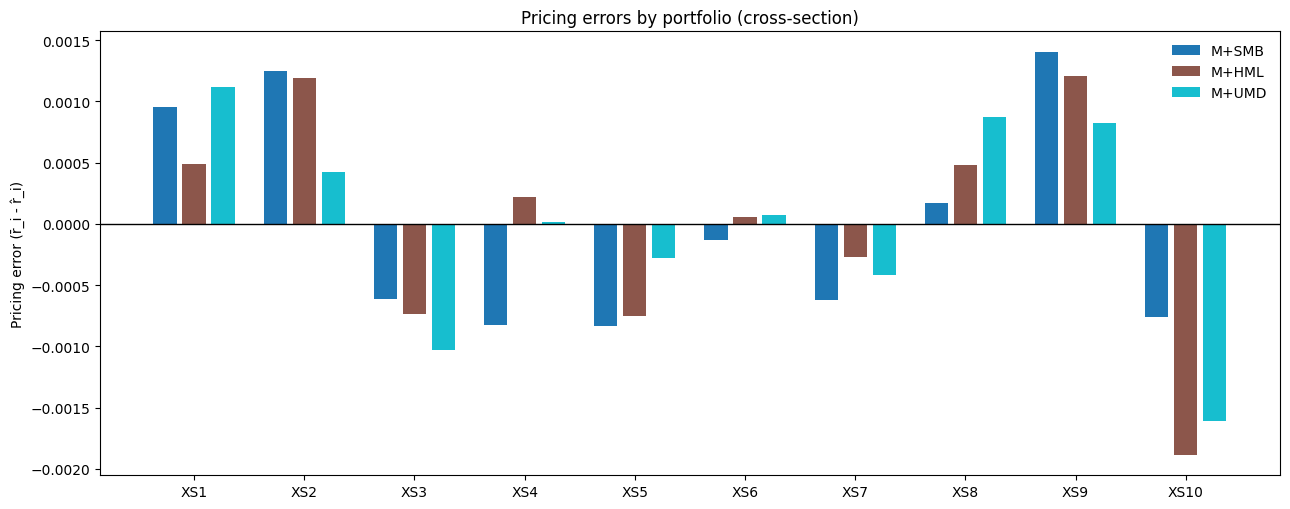

In [22]:
fig = plot_cs_pricing_errors(resid1, resid2, resid3, filename="cross-section_pricing_errors.png")

In [33]:
def plot_factor_decomp(betas_df, tab, spec_label,
                              out_path=out_path, filename="factor_decomp.png",
                              use_abs=False):
    """
    Factor decomposition per portfolio: barre impilate Market + X (SMB/HML/UMD).
    - betas_df: DataFrame index=XS1..XS10, columns=['beta_M', 'beta_SMB'|'beta_HML'|'beta_UMD']
    - tab: tabella risultati cross-section (tab1/tab2/tab3) con righe 'beta_M' e fattore X, colonna 'coef'
    - spec_label: stringa breve per il titolo (es. "M+HML")
    - use_abs: se True usa contributi in valore assoluto (più “intuitivo” se i premi sono negativi)
    """

    # Ordina XS1..XS10 se possibile
    try:
        betas_df = betas_df.loc[sorted(betas_df.index, key=lambda x: int(''.join([c for c in x if c.isdigit()])))].copy()
    except Exception:
        betas_df = betas_df.copy()

    # secondo fattore
    xcol = [c for c in betas_df.columns if c != "beta_M"][0]
    xname = xcol.replace("beta_", "").upper()

    # coefficienti cross-section (premi stimati)
    bM_cs = tab.loc["beta_M", "coef"]
    bX_cs = tab.loc[xcol,   "coef"]

    # contributi per portfolio
    contr_M = betas_df["beta_M"] * bM_cs
    contr_X = betas_df[xcol]   * bX_cs
    if use_abs:
        contr_M = contr_M.abs()
        contr_X = contr_X.abs()

    pf = betas_df.index.to_list()
    x = np.arange(len(pf))

    fig, ax = plt.subplots(figsize=(max(8, 0.9*len(pf)+4), 5.2))
    ax.bar(x, contr_M.values, label="Market", width=0.8)
    ax.bar(x, contr_X.values, bottom=contr_M.values, label=xname, width=0.8)

    ax.axhline(0, color='black', linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(pf)
    ax.set_ylabel("Contribution to mean excess return")
    ax.set_title(f"Factor decomposition — {spec_label}")
    ax.legend(frameon=False, loc='best')

    fig.tight_layout()
    fig.savefig(f"{out_path}{filename}", dpi=300, bbox_inches="tight")
    return fig

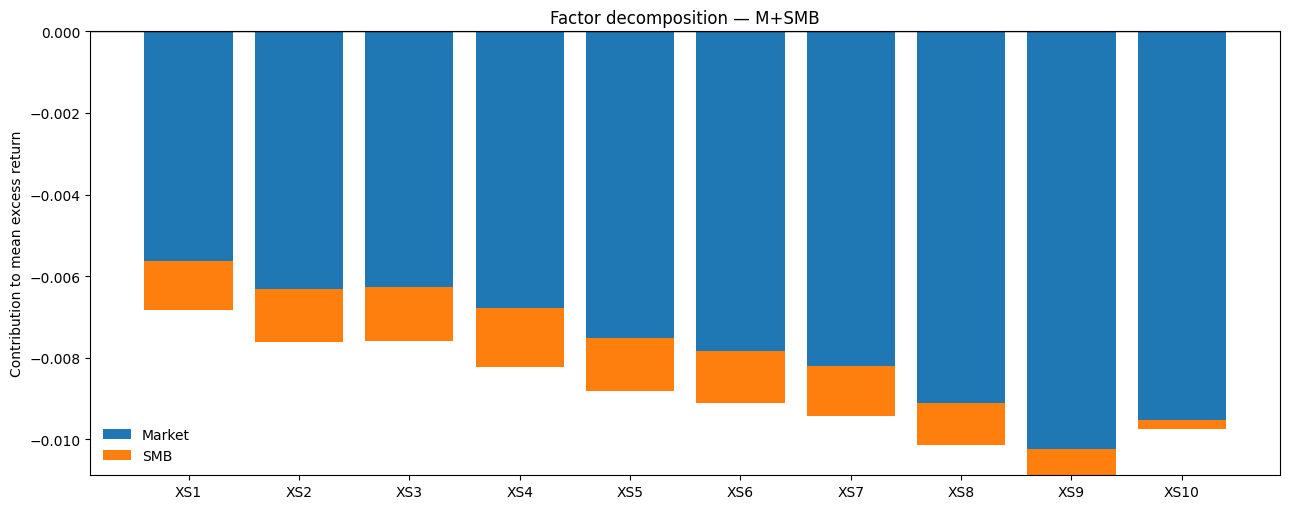

In [34]:
# M+SMB
fig = plot_factor_decomp(betas[["beta_M","beta_SMB"]], tab1, "M+SMB", filename="factor_decomp_M_SMB.png", use_abs=False)

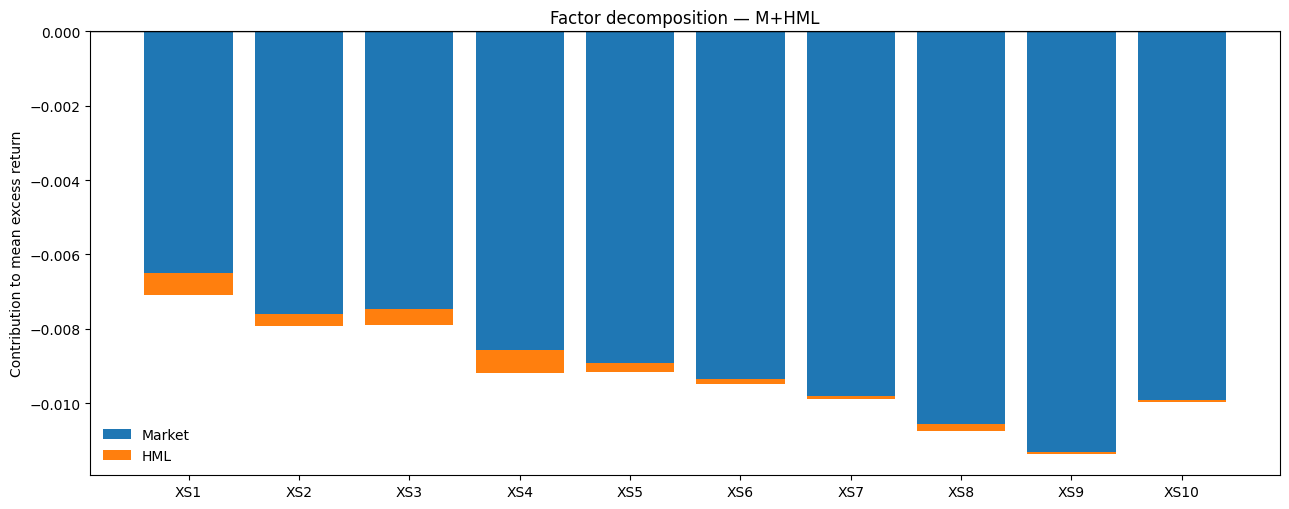

In [35]:
# M+HML
fig = plot_factor_decomp(betas[["beta_M","beta_HML"]], tab2, "M+HML", filename="factor_decomp_M_HML.png", use_abs=False)

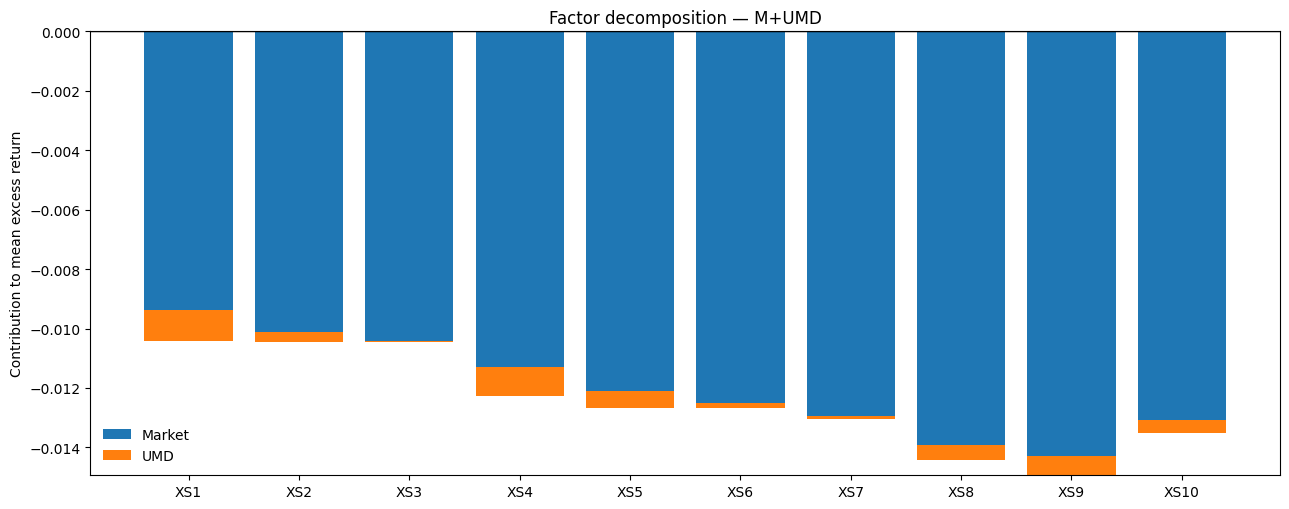

In [36]:
# M+UMD
fig = plot_factor_decomp(betas[["beta_M","beta_UMD"]], tab3, "M+UMD", filename="factor_decomp_M_UMD.png", use_abs=False)

In [46]:
def _format_p(p):
    import numpy as np
    if np.isnan(p): return ""
    return f"{p:.3f}" if p >= 1e-3 else f"{p:.1e}"

def plot_cs_pvalue_heatmap(tab1, tab2, tab3, include_const=False,
                           thresholds=(0.10, 0.05, 0.03, 0.01),
                           title="Cross-section p-values",
                           filename="cs_pvalues_heatmap.png", out_path=out_path):
    """
    Heatmap dei p-value per le tre cross-section: M+SMB, M+HML, M+UMD.
    - Usa le colonne 'coef' e 'p>|t|' nelle tabelle tab1/tab2/tab3 (come create da run_cs_reg).
    - Colonne della heatmap: ['beta_M','beta_SMB','beta_HML','beta_UMD'] (+ 'const' opzionale).
    - Le celle non applicabili sono mascherate (vuote).
    """

    rows = [("M+SMB", tab1), ("M+HML", tab2), ("M+UMD", tab3)]
    cols = ["beta_M", "beta_SMB", "beta_HML", "beta_UMD"]
    if include_const:
        cols = ["const"] + cols

    # Costruisci matrice p-value (righe = specifiche, colonne = fattori)
    M = pd.DataFrame(np.nan, index=[r[0] for r in rows], columns=cols, dtype=float)
    for name, tab in rows:
        for c in cols:
            if c in tab.index:
                M.loc[name, c] = tab.loc[c, "p>|t|"]
    
    # Mapping da beta_* → λ_*
    label_map = {
        "const": "const",
        "beta_M": "λ_M",
        "beta_SMB": "λ_SMB",
        "beta_HML": "λ_HML",
        "beta_UMD": "λ_UMD"
    }
    display_labels = [label_map.get(c, c) for c in M.columns]

    # Palette e soglie (come nel punto 2)
    colors = ["#f2f5fa", "#c9d8f2", "#9cbce8", "#669dd6", "#2c7bb6"]
    t1, t2, t3, t4 = thresholds
    bins = [0.0, t4, t3, t2, t1, 1.0]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(bins, cmap.N, clip=True)

    # Maschera celle NaN (fattori non presenti nella specifica)
    P = M.values.astype(float)
    Pm = ma.masked_invalid(P)

    fig, ax = plt.subplots(figsize=(1.2*len(cols)+3, 0.9*len(M.index)+2))
    ny, nx = P.shape
    X, Y = np.meshgrid(np.arange(nx+1), np.arange(ny+1))

    hm = ax.pcolormesh(X, Y, Pm, cmap=cmap, norm=norm, shading='flat',
                       edgecolors='face', linewidth=0, antialiased=False)

    # ticks
    ax.set_xticks(np.arange(nx) + 0.5)
    ax.set_xticklabels(display_labels, rotation=45, ha='right')
    ax.set_yticks(np.arange(ny) + 0.5)
    ax.set_yticklabels(M.index)

    # annotazioni
    for i in range(ny):
        for j in range(nx):
            if not np.isnan(P[i, j]):
                ax.text(j+0.5, i+0.5, _format_p(P[i, j]),
                        ha='center', va='center', fontsize=9, color='black')

    # griglia bianca sottile
    ax.set_xticks(np.arange(nx+1), minor=True)
    ax.set_yticks(np.arange(ny+1), minor=True)
    ax.grid(which='minor', color='white', linewidth=0.8)
    ax.tick_params(which='minor', bottom=False, left=False)

    # colorbar categoriale
    cbar = fig.colorbar(hm, ax=ax,
                        ticks=[(bins[k]+bins[k+1])/2 for k in range(len(bins)-1)])
    cbar.ax.set_yticklabels([
        "< 0.01 (highly significant)",
        "0.01–0.03 (very significant)",
        "0.03–0.05 (significant)",
        "0.05–0.10 (marginally significant)",
        "> 0.10 (not significant)"
    ])
    cbar.set_label("p-value")

    ax.set_xlim(0, nx)
    ax.set_ylim(ny, 0)
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(f"{out_path}{filename}", dpi=300, bbox_inches="tight")
    return fig

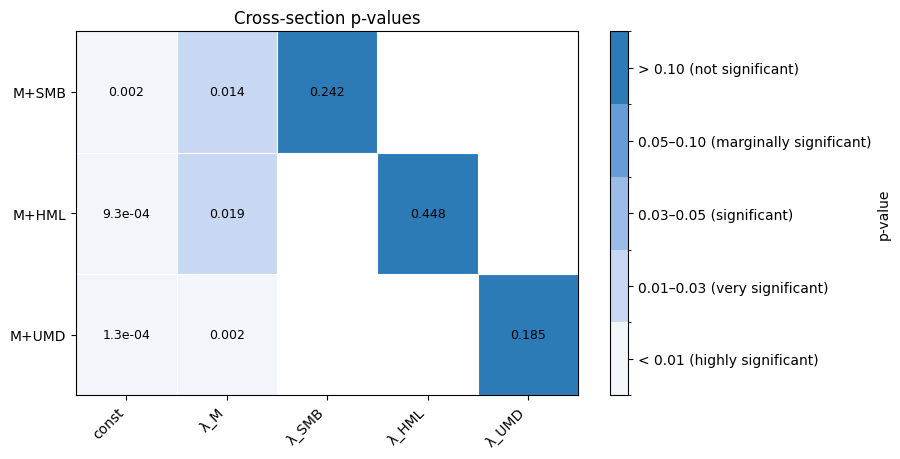

In [47]:
fig = plot_cs_pvalue_heatmap(tab1, tab2, tab3, include_const=True, filename="cross-section_pvalues_heatmap.png")

In [48]:
def plot_adj_r2_bar(met1, met2, met3, out_path=out_path,
                    title="Adjusted R² by specification",
                    filename="adj_r2_cs.png"):
    """
    Bar chart degli Adjusted R² per le tre cross-section (M+SMB, M+HML, M+UMD).
    - met1/met2/met3: Series o dict con chiavi 'spec', 'r2_adj' (come restituito da run_cs_reg).
    """
    import numpy as np
    import matplotlib.pyplot as plt

    specs = ["M+SMB", "M+HML", "M+UMD"]
    r2a_vals = [
        float(met1["r2_adj"]),
        float(met2["r2_adj"]),
        float(met3["r2_adj"]),
    ]

    x = np.arange(len(specs))
    fig, ax = plt.subplots(figsize=(6.5, 4.2))
    bars = ax.bar(x, r2a_vals, width=0.8)

    # etichette sopra la barra (in % con una cifra decimale)
    for rect, v in zip(bars, r2a_vals):
        ax.text(rect.get_x() + rect.get_width()/2,
                rect.get_height() + 0.01,
                f"{v*100:.1f}%", ha='center', va='bottom', fontsize=10)

    ax.set_xticks(x)
    ax.set_xticklabels(specs)
    ax.set_ylim(0, max(0.05, max(r2a_vals)*1.15))  # piccolo margine sopra
    ax.set_ylabel("Adjusted R²")
    ax.set_title(title)
    ax.axhline(0, color='black', linewidth=1)

    fig.tight_layout()
    fig.savefig(f"{out_path}{filename}", dpi=300, bbox_inches="tight")
    return fig

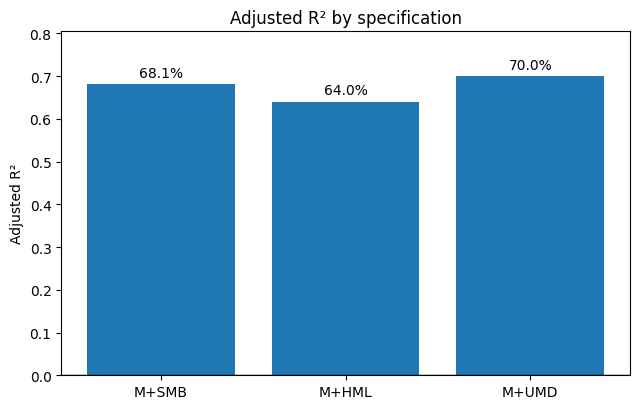

In [49]:
fig = plot_adj_r2_bar(met1, met2, met3, filename="adj_r2.png")